# The 8 schools example

The "8 schools" example is a famous example of a hierarchical (multi-level) model with so-called "partial pooling." The data comes from a study of coaching programs for the Verbal SAT (for those unfamiliar, the SAT is one of two major standardized tests used in undergraduate college/university admissions in the US).

Let's do our imports and load the data.

In [1]:
import numpy as np, scipy as sp, pymc3 as pm, pandas as pd, arviz as az
import matplotlib.pyplot as plt
from scipy import stats

d = {'School': ['A','B','C','D','E','F','G','H'],
     'Effect': [28, 8, -3, 7, -1, 1, 18, 12],
     'SE': [15, 10, 16, 11, 9, 11, 10, 18]}
schools = pd.DataFrame(data=d)
schools

,School,Effect,SE
0,A,28,15
1,B,8,10
2,C,-3,16
3,D,7,11
4,E,-1,9
5,F,1,11
6,G,18,10
7,H,12,18


The estimates $y_i$ of the effects are obtained by independent experiments carried out at each school. The estimates are not simple sample means, as they underwent some adjustment procedures, but they can be assumed to have approximately normal sampling distributions with known standard errors (in the above table).

## Hierarchical model

We presume that the estimates $y_i$ are produced by 8 independent normal distributions with their own means $\theta_i$ and variances $\sigma^2_i$:

$$ y_i | \theta_i, \sigma^2_i \sim N(\theta_i, \sigma_i) $$

We presume that the parameters $\theta_i$ are themselves drawn from a normal distribution with parameters $\mu, \tau$. Given $\mu, \tau$, we assume the $\theta_i$'s to be conditionally independent. For convenience, we presume the sampling standard deviations of the $\bar y_i$ to be known and equal to the values in the data table.

We start with a centered parameterization:

$$
\begin{align}
y_i &\sim \mathrm{Normal}(\theta_i, \sigma_i) \\
\theta_i &\sim \mathrm{Normal}(\mu, \tau) \\
\mu &\sim \mathrm{Normal}(0, 5) \\
\tau &\sim \mathrm{HalfCauchy}(5)
\end{align}
$$

As we'll see, this doesn't perform well -- we get many divergences.

In [2]:
with pm.Model() as centered_model:
    # Hyperparameters
    μ = pm.Normal('μ', 0, 5)
    τ = pm.HalfCauchy('τ', 5)
    
    # Parameter vector
    θ = pm.Normal('θ', mu = μ, sigma = τ, shape = 8)
    
    # Data likelihood
    y_ = pm.Normal('y', mu = θ, sigma = schools['SE'], observed = schools['Effect'])
    
    centered_trace = pm.sample(3000, chains=4, target_accept = 0.95, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [θ, τ, μ]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 26 seconds.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 80 divergences after tuning. Increase `target_accept` or reparameterize.
There were 101 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8575077306893503, but should be close to 0.95. Try to increase the number of tuning steps.
There were 83 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.82701762879557, but should be close to 0.95. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


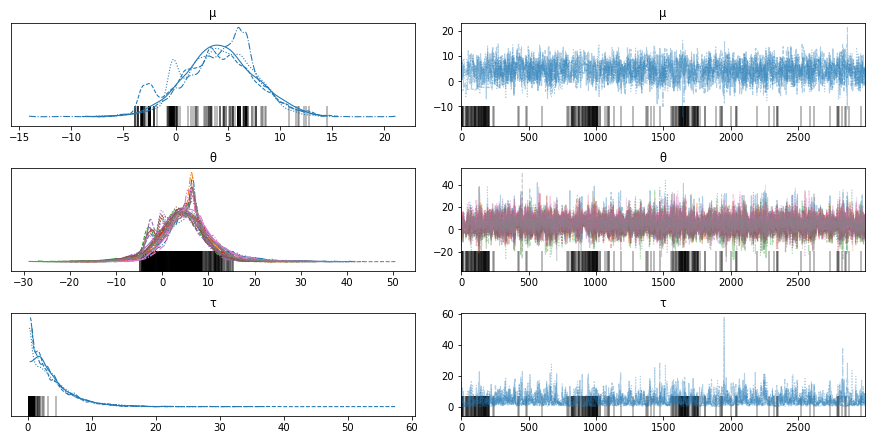

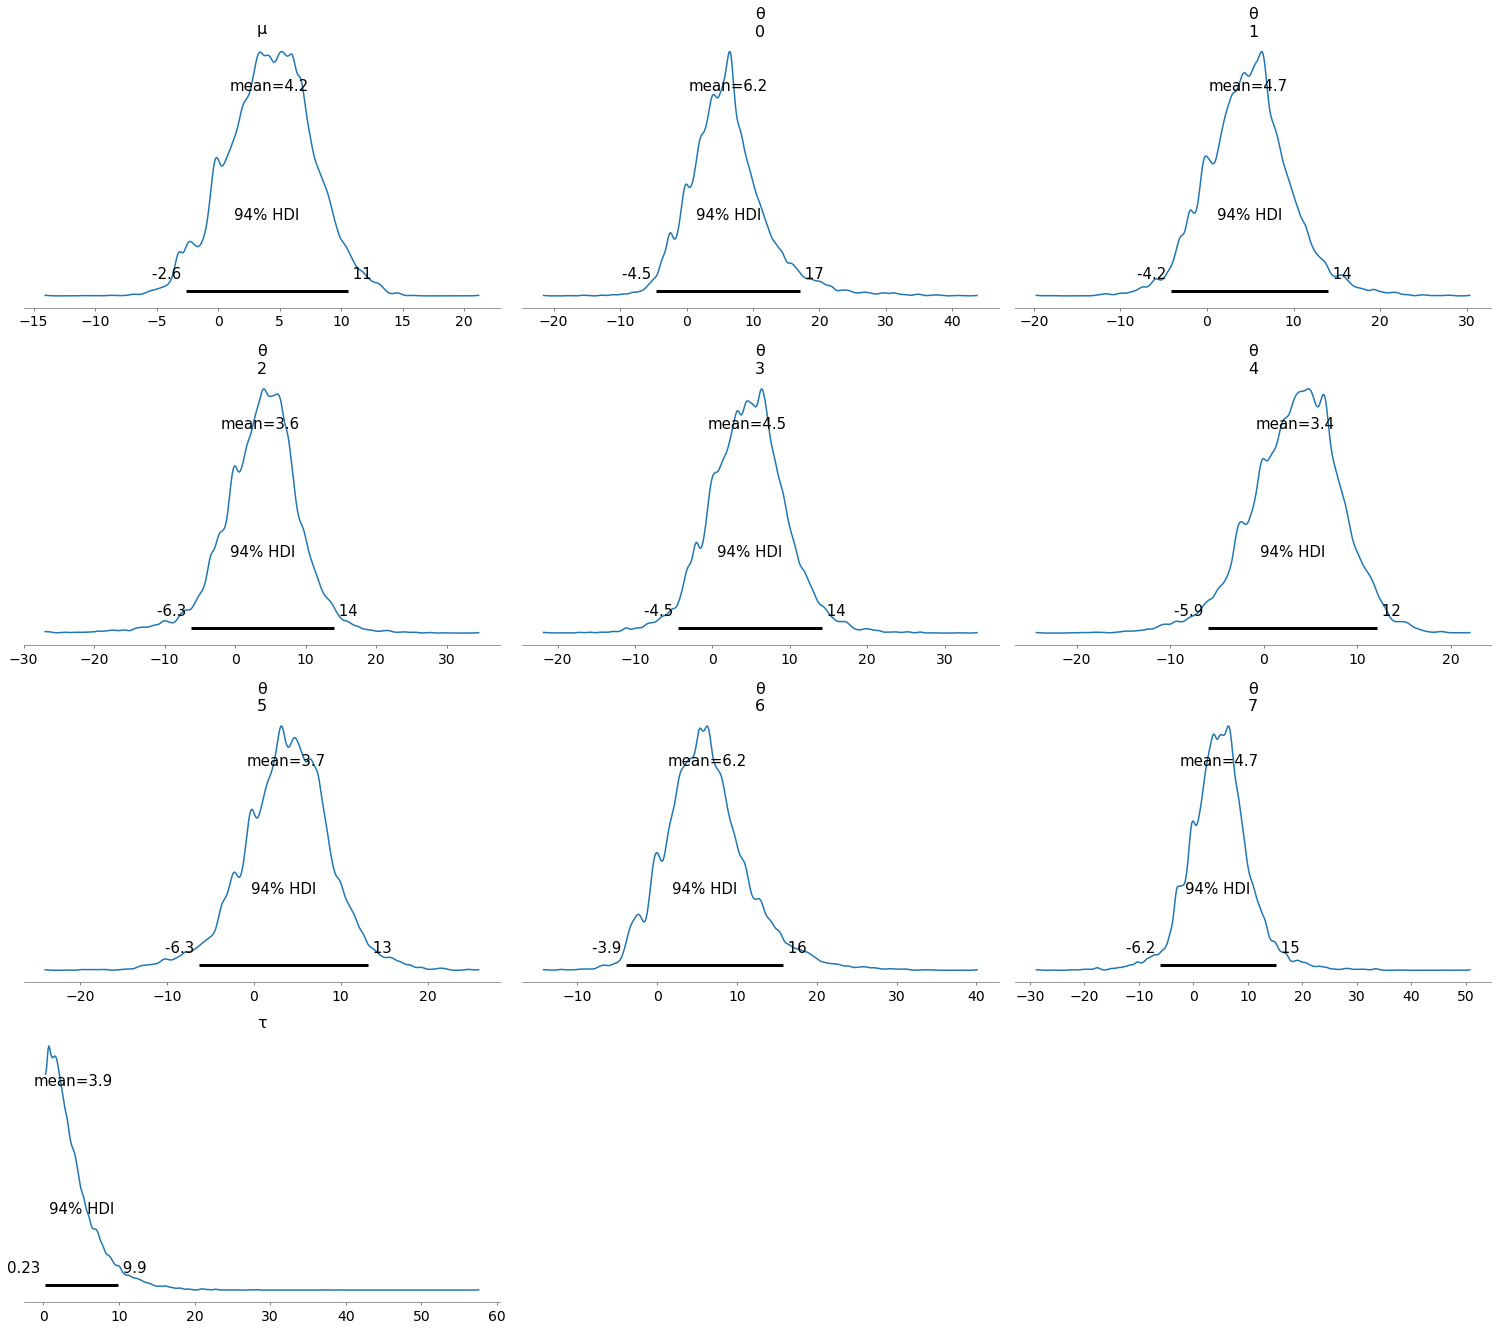

In [3]:
with centered_model:
    az.plot_trace(centered_trace)
    az.plot_posterior(centered_trace)

To investigate the divergences, we use a pairplot:

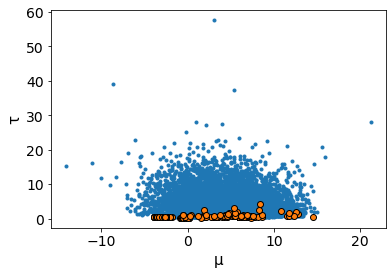

In [4]:
with centered_model:
    az.plot_pair(centered_trace, divergences=True, var_names = ['μ', 'τ'])

We see the divergences concentrating toward smaller values of $\tau$, at the opening of the hierarchical "funnel." To correct this, we can switch to a non-centered parameterization.

$$
\begin{align}
y_i &\sim \mathrm{Normal}(\theta_i, \sigma_i) \\
\theta_i &= \mu + \tau \eta \\
\mu &\sim \mathrm{Normal}(0, 5) \\
\tau &\sim \mathrm{HalfCauchy}(5) \\
\eta &\sim \mathrm{Normal}(0, 1)
\end{align}
$$

In [11]:
with pm.Model() as noncentered_trace:
    # Hyperparameters
    μ = pm.Normal('μ', 0, 5)
    τ = pm.HalfCauchy('τ', 5)
    η = pm.Normal('η', 0, 1, shape = 8)
    
    # Parameter vector
    θ = pm.Deterministic('θ', μ + τ * η)
    
    # Data likelihood
    y_ = pm.Normal('y', mu = θ, sigma = schools['SE'], observed = schools['Effect'])
    
    noncentered_trace = pm.sample(3000, chains=4, target_accept = 0.95, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [η, τ, μ]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 13 seconds.


### Comparing to a fully un-pooled model

For comparison, we fit an un-pooled model, where each $\theta$ is drawn independently from a common normal distribution that has fixed parameters.

In [12]:
with pm.Model() as separate_model:
    # Prior for means
    θ = pm.Normal('θ', 0, 10, shape = 8)

    y_obs = pm.Normal('y_obs', mu = θ, sigma = schools['SE'], observed = schools['Effect'])
    
    sep_trace = pm.sample(3000, chains=4, target_accept = 0.95, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [θ]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 7 seconds.


In [13]:
az.loo(sep_trace, pointwise = True)

Computed from 12000 by 8 log-likelihood matrix

         Estimate       SE
elpd_loo   -31.98     1.31
p_loo        2.18        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        5   62.5%
 (0.5, 0.7]   (ok)          3   37.5%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [14]:
az.loo(hier_trace, pointwise = True)

Computed from 12000 by 8 log-likelihood matrix

         Estimate       SE
elpd_loo   -30.47     1.34
p_loo        0.51        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        8  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [15]:
az.compare({'separate':sep_trace, 'hierarchical':hier_trace})

/home/dylan/.conda/envs/info510/lib/python3.8/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
hierarchical,0,-30.474629,0.513573,0.000000,1.0,1.337053,0.00000,False,log
separate,1,-31.983930,2.176795,1.509301,0.0,1.309665,0.37746,False,log


The comparison based on PSIS-LOO shows a slight advantage for the hierarchical model.